In [38]:
from pathlib import Path

In [39]:
# size = 112
size = 56
image_class_paths = [Path('./image_classes')]

## Check Hardware and Tools

In [40]:
import tensorflow as tf

In [41]:
tf.__version__

'1.4.0'

In [42]:
from tensorflow.python.client import device_lib

In [43]:
for d in device_lib.list_local_devices():
    print(d)

name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12411798709480598135

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 1
}
incarnation: 10528124149017856693
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"



## Resize Input Images

In [291]:
from matplotlib import pyplot as plt
%matplotlib inline

In [292]:
from skimage.transform import resize

In [293]:
from pathlib import Path
from PIL import Image
import numpy as np
import pickle

In [294]:
image_classes_path = Path('./image_classes')
image_class_resized_path = [Path('./image_classes_resized')]
# image_class_resized_path = [Path('./image_classes_resized'), Path('./theo_image_classes_resized')]

In [296]:
def resize_images(image_classes_path):
    for p in image_classes_path.glob('*/*/*.pkl'):
        _, ds, cl, mol = p.parts
        p_r = Path(str(image_classes_path) + '_resized') / ds / cl / mol
        if not p_r.parent.exists():
            p_r.parent.mkdir(parents=True)

        img = np.load(open(p, 'rb'))
        img_r = resize(img, (size, size), mode='reflect')
        img_r.dump(open(p_r, 'wb'))

for path in image_class_paths:
    resize_images(path)

In [297]:
p = Path('image_classes_resized/0600145A6-/neg/C20H34O2-H.pkl')

In [300]:
img = np.load(open(p, 'rb'))
img.shape

(56, 56)

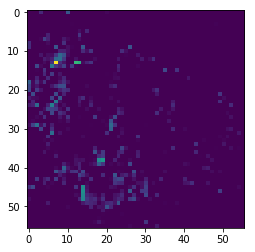

In [301]:
plt.imshow(img)

## Load Input Data

In [44]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

In [45]:
from matplotlib import pyplot as plt
%matplotlib inline

In [46]:
# image_data_path = Path('./image_classes_resized')
# image_data_path = Path('./theo_image_classes_resized')
image_class_paths

[PosixPath('image_classes'), PosixPath('theo_image_classes_orbi_na')]

In [47]:
images = []  # images
groups = []  # datasets
labels = []  # classes
for image_class_path in map(lambda p: Path(str(p) + '_resized'), image_class_paths):
    print(image_class_path)
    for p in image_class_path.glob('*/*/*.pkl'):
        _, ds_name, cl, _ = p.parts
        img = np.load(open(p, 'rb'))
        images.append(img)
        groups.append(ds_name)
        labels.append(1 if cl == 'pos' else 0)

# order = np.arange(0, len(images))
# np.random.shuffle(order)
images = np.asarray(images).astype('float32')
groups = np.asarray(groups)
classes = np.asarray(labels).astype('float32').reshape((-1,1))

images.shape, classes.shape, groups.shape

image_classes_resized
theo_image_classes_orbi_na_resized


((23206, 56, 56), (23206, 1), (23206,))

In [48]:
group_list = np.unique(groups).tolist()
groups_n = len(group_list)
groups_n

102

In [49]:
df = pd.DataFrame({'label': labels, 'gr': groups, 'v': 1})
gr = df.groupby(['gr', 'label'])
df2 = gr.count().reset_index()
df3 = pd.pivot(index=df2.gr, columns=df2.label, values=df2.v).reset_index()
df3.columns = ['gr', 'neg', 'pos']
# df3

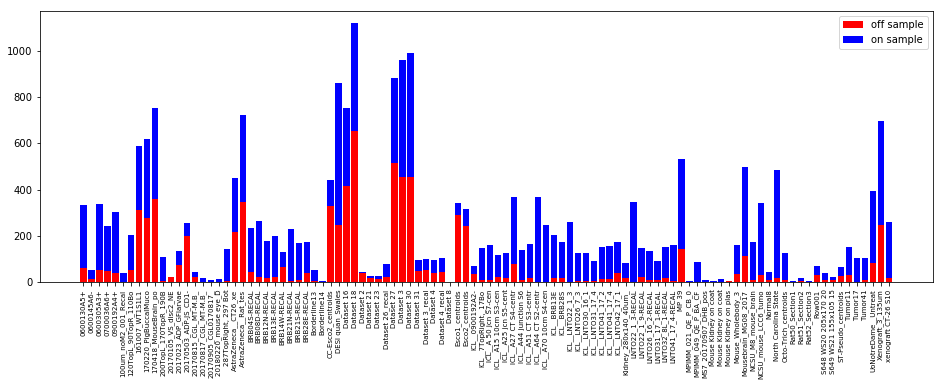

In [50]:
fig, ax = plt.subplots(figsize=(16, 5))
x = np.arange(df3.shape[0])
rect1 = ax.bar(x, df3.pos, color='red')
rect2 = ax.bar(x, df3.neg, bottom=df3.pos, color='blue')
ax.set_xticks(x)
ax.set_xticklabels(df3.gr.map(lambda s: s[:20]), rotation=90, fontdict={'size': 7});
ax.legend((rect1, rect2), ('off sample', 'on sample'))

In [51]:
df3[['neg', 'pos']].sum()

neg    15665.0
pos     7541.0
dtype: float64

In [54]:
# img = np.load('/data/intsco/capstone/theo_image_classes_orbi_na_resized/NCSU_M8_mouse_brain/pos/C19H12O6+H.pkl')
# plt.imshow(resize(img, (size, size), mode='edge'))

## Data Augmentation

In [413]:
import keras
from keras.preprocessing.image import ImageDataGenerator

In [386]:
X = images.reshape((-1, size, size, 1))
y = keras.utils.to_categorical(classes, 2)
X.shape, y.shape

((23206, 56, 56, 1), (23206, 2))

In [411]:
image_data_gen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     zca_whitening=True,
#     rotation_range=90,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=0.3
    )

In [407]:
# image_data_gen.fit(X)

/home/ubuntu/src/anaconda3/envs/off-smpl/lib/python3.6/site-packages/keras/preprocessing/image.py:506: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ubuntu/src/anaconda3/envs/off-smpl/lib/python3.6/site-packages/keras/preprocessing/image.py:514: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


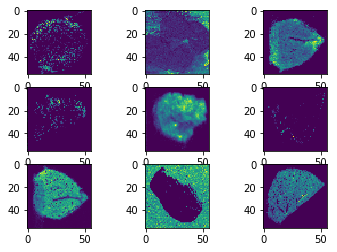

In [408]:
for X_batch, y_batch in image_data_gen.flow(X, y, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i][:,:,0], cmap='viridis')
	# show the plot
	plt.show()
	break

In [57]:
# scaling_factor = 3
# neg_n = (y_gr[:,1] == 0).sum()
# pos_n = (y_gr[:,1] == 1).sum()
# n = X_gr.shape[0]
# m = scaling_factor * n
# aug_neg_n = aug_pos_n = m // 2
# aug_neg_n, aug_pos_n

In [27]:
def augment_group_class(X, y, cl, size):
    batch_size = 32
    gen = image_data_gen.flow(X, y, batch_size=1)
    X_aug_l, y_aug_l = [], []
    n = 0
    while True:
        X_a, y_a = next(gen)
        X_aug_l.append(X_a)
        y_aug_l.append(y_a)

        n += X_a.shape[0]
        if n >= size:
            break
    return np.concatenate(X_aug_l), np.concatenate(y_aug_l)

In [28]:
def augment_group(X, y, size=1024):
    X_cl_aug_l, y_cl_aug_l = [], []
    for cl in [0, 1]:
        mask = y[:,1] == cl
        X_cl, y_cl = X[mask], y[mask]
        X_cl_aug, y_cl_aug = augment_group_class(X_cl, y_cl, cl, size=size//2)
#         print(X_cl_aug.shape)
        X_cl_aug_l.append(X_cl_aug), y_cl_aug_l.append(y_cl_aug)
    
    order = np.arange(0, size)
    np.random.shuffle(order)
    
    return np.concatenate(X_cl_aug_l)[order], np.concatenate(y_cl_aug_l)[order]

In [29]:
group_list = np.unique(groups)
group_list

array(['120TopL_90TopR_110BottomL_100BottomR-centroid', '161007_WT1S1L1',
       '170220_PigBuccalMucosaAzDiaz1h_10um_231by185_atn30',
       '170418_MouseBrain_pos_50um_205by129_atn0',
       '20170503_ADP-JS_CD1-Brain_dan005_117x143_60x60_N',
       'AstraZeneca__Rat_testis', 'CC-Esco2_centroids', 'Dataset 16',
       'Dataset 18', 'Dataset 27', 'Dataset 3', 'Dataset 30',
       'Esco1_centroids', 'Esco2_centroids', 'MP 39',
       'Mousebrain_MG08_2017_GruppeA', 'Tumor11',
       'UoNotreDame__Untreated_6_574', 'Xenograft_3_135um'],
      dtype='<U50')

In [30]:
def augment_data(X, y, groups, group_list, size=1024):
    X_l, y_l, gr_l = [], [], []
    for gr in group_list:
        X_a, y_a = augment_group(X[groups == gr], y[groups == gr], size=size)
        X_l.append(X_a)
        y_l.append(y_a)
        gr_l.append([gr]*X_a.shape[0])
    return np.concatenate(X_l), np.concatenate(y_l), np.concatenate(gr_l)

In [31]:
# group_list = np.unique(groups)
# X_aug, y_aug, groups_aug = augment_data(X, y, groups, group_list)

# X_aug.shape, y_aug.shape, y_aug[:,0].sum(), y_aug[:,1].sum(), groups_aug.shape
# plt.imshow(X_aug[31,:,:,0]), y_aug[31,1]

## Train and Test Model

In [1]:
import keras
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

Using TensorFlow backend.
/home/ubuntu/src/anaconda3/envs/off-smpl/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from keras import losses
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

In [3]:
def train_valid_test_split(X, y, groups, test_group, valid_ratio=0.5):
    group_list = np.unique(groups)
    group_list = group_list[group_list != test_group]

    from sklearn.model_selection import train_test_split
    train_groups, valid_groups = train_test_split(group_list, test_size=valid_ratio)

    test_mask = groups == test_group
    X_test, y_test = X[test_mask], y[test_mask]

    valid_mask = np.asarray([gr in valid_groups for gr in groups])
    X_valid, y_valid = X[valid_mask], y[valid_mask]

    train_mask = ~(test_mask|valid_mask)
    X_train, y_train = X[train_mask], y[train_mask]
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [4]:
def train_valid_test_gen(X, y, groups, valid_ratio=0.5):
    for test_group in np.unique(groups):
        yield train_valid_test_split(X, y, groups, test_group, valid_ratio=valid_ratio)

In [5]:
#     earlyStopping = EarlyStopping(monitor='loss', min_delta=0.01)

In [6]:
def calc_metrics(y_test, y_test_score):
    y_true = y_test[:,1]
    y_test_pred = np.round(y_test_score[:,1], decimals=0)

    return {
        'auc': roc_auc_score(y_test, y_test_score),
        'accuracy': accuracy_score(y_true, y_test_pred),
        'f1': f1_score(y_true, y_test_pred),
        'precision': precision_score(y_true, y_test_pred),
        'recall': recall_score(y_true, y_test_pred)
   }

#### Fitting Model

In [14]:
def create_model(opt='adam', metrics=None):
    model = Sequential()
    
    alpha = 0.05
    strides = (1, 1)
    pool_size = (3, 3)
    model.add(Conv2D(16, 3, strides=strides, padding='same', input_shape=(size, size, 1),
                     kernel_regularizer=l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(16, 3, strides=strides, padding='same',
                    kernel_regularizer=l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Conv2D(32, 3, strides=strides, padding='same',
                     kernel_regularizer=l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, 3, strides=strides, padding='same',
                     kernel_regularizer=l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Flatten())
    
    model.add(Dense(256, kernel_regularizer=l2(alpha)))
    model.add(Activation('relu'))
#     model.add(Dropout(0.5))
    
    model.add(Dense(256, kernel_regularizer=l2(alpha)))
    model.add(Activation('relu'))
#     model.add(Dropout(0.5))
    
    model.add(Dense(2, kernel_regularizer=l2(alpha)))
    model.add(Activation('softmax'))
    
    if not metrics:
        metrics = [keras.metrics.binary_accuracy]
    model.compile(loss=losses.binary_crossentropy, optimizer=opt, metrics=metrics)
    
    return model
create_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 56, 56, 16)        160       
_________________________________________________________________
batch_normalization_5 (Batch (None, 56, 56, 16)        64        
_________________________________________________________________
activation_8 (Activation)    (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 16)        2320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 56, 56, 16)        64        
_________________________________________________________________
activation_9 (Activation)    (None, 56, 56, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 16)        0         
__________

In [13]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(create_model()).create(prog='dot', format='svg'))

In [55]:
from keras.preprocessing.image import ImageDataGenerator
image_data_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rescale=0.3)

In [56]:
X = images.reshape((-1, size, size, 1))
y = keras.utils.to_categorical(classes, 2)
X.shape, y.shape  #X_aug.shape, y_aug.shape, groups_aug.shape

((23206, 56, 56, 1), (23206, 2))

In [415]:
batch_size = 32
epochs = 3
verbose = 1
n = 5
metrics = []
# for test_group in group_list:
# for test_group in ['Mousebrain_MG08_2017_GruppeA']: #['Dataset 18', 'MP 39']:
#     res = train_valid_test_split(X, y, groups, test_group, valid_ratio=0.0)
#     (X_train, y_train), (X_valid, y_valid), (X_test, y_test) = res

from sklearn.model_selection import GroupKFold

gkfold = GroupKFold(n_splits=10)
for split_i, (train_inds, test_inds) in enumerate(gkfold.split(X, y, groups)):
    X_train, y_train = X[train_inds], y[train_inds]
    X_test, y_test = X[test_inds], y[test_inds]
    
    image_data_gen.fit(X_train)
    
#     print(np.unique(groups[test_inds]))
    print('Split:', split_i)

    y_test_score_avg = np.zeros(y_test.shape)
    for i in range(n):
        print('Attempt:', i)

        model = create_model(metrics=['accuracy'],
                             opt=SGD(lr=0.01, momentum=0.9, decay=0, nesterov=False))
#         model.fit(X_train, y_train,
# #                   validation_data=(X_valid, y_valid),
#                   batch_size=batch_size, epochs=epochs, verbose=verbose)
        model.fit_generator(image_data_gen.flow(X_train, y_train),
                            steps_per_epoch=X_train.shape[0]//batch_size*2, epochs=epochs, verbose=verbose)
        
        y_test_score = model.predict(X_test, verbose=verbose)
        y_test_score_avg += y_test_score
        
        test_m = calc_metrics(y_test, y_test_score)
#         test_m['model'] = model
#         test_m['group'] = test_group
        test_m['split'] = str(split_i)
        test_m['attempt'] = str(i)
        metrics.append(test_m)
        print(test_m)
    
    y_test_score_avg /= n
    test_m_avg = calc_metrics(y_test, y_test_score_avg)
#     test_m_avg['group'] = test_group
    test_m_avg['split'] = str(split_i)
    test_m_avg['attempt'] = 'avg'
    metrics.append(test_m_avg)
    print()
    print('Avg pred metrics:', test_m_avg)
    print()

metrics_df = pd.DataFrame(metrics)
metrics_df.to_pickle('train_res.pkl')
metrics_df

/home/ubuntu/src/anaconda3/envs/off-smpl/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (20887, 56, 56, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Split: 0
Attempt: 0
Epoch 1/3
1304/1304 [==============================] - 51s - loss: 1.8181 - acc: 0.9710    
Epoch 2/3
1304/1304 [==============================] - 38s - loss: 0.1863 - acc: 0.9773    
Epoch 3/3
2240/2319 [===========================>..] - ETA: 0s{'auc': 0.99762044139671713, 'accuracy': 0.98835705045278133, 'f1': 0.98632911392405054, 'precision': 0.9878296146044625, 'recall': 0.98483316481294236, 'split': '0', 'attempt': '0'}
Attempt: 1
Epoch 1/3
1304/1304 [==============================] - 50s - loss: 1.7673 - acc: 0.9760    
Epoch 2/3
1304/1304 [==============================] - 36s - loss: 0.1853 - acc: 0.9789    
Epoch 3/3
2319/2319 [==============================] - 10s    
{'auc': 0.99287880976455289, 'accuracy': 0.95644674428633036, 'f1': 0.95094706168042742, 'precision': 0.91495327102803736, 'recall': 0.98988877654196161, 'split': '0', 'attempt': '1'}
Attempt: 2
Epoch 1/3
1304/1304 [==============================] - 51s - loss: 1.7722 - acc: 0.9732    
Epoch 

/home/ubuntu/src/anaconda3/envs/off-smpl/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (20882, 56, 56, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Split: 2
Attempt: 0
Epoch 1/3
1304/1304 [==============================] - 54s - loss: 1.7726 - acc: 0.9754    
Epoch 2/3
1304/1304 [==============================] - 39s - loss: 0.1802 - acc: 0.9766    
Epoch 3/3
2208/2324 [===========================>..] - ETA: 0s{'auc': 0.99713843206354547, 'accuracy': 0.82874354561101549, 'f1': 0.7805953693495038, 'precision': 0.64014466546112114, 'recall': 1.0, 'split': '2', 'attempt': '0'}
Attempt: 1
Epoch 1/3
1304/1304 [==============================] - 48s - loss: 1.7914 - acc: 0.9722    
Epoch 2/3
1304/1304 [==============================] - 37s - loss: 0.1819 - acc: 0.9778    
Epoch 3/3
2324/2324 [==============================] - 11s    
{'auc': 0.99873528136711975, 'accuracy': 0.98364888123924266, 'f1': 0.97372060857538034, 'precision': 0.95392953929539293, 'recall': 0.99435028248587576, 'split': '2', 'attempt': '1'}
Attempt: 2
Epoch 1/3
1304/1304 [==============================] - 55s - loss: 1.7767 - acc: 0.9739    
Epoch 2/3
1304/1304 [=

/home/ubuntu/src/anaconda3/envs/off-smpl/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (20885, 56, 56, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Split: 3
Attempt: 0
Epoch 1/3
1304/1304 [==============================] - 56s - loss: 1.7763 - acc: 0.9736    
Epoch 2/3
1304/1304 [==============================] - 41s - loss: 0.1867 - acc: 0.9760    
Epoch 3/3
2304/2321 [============================>.] - ETA: 0s{'auc': 0.99872464704237918, 'accuracy': 0.97673416630762599, 'f1': 0.96361185983827491, 'precision': 0.934640522875817, 'recall': 0.99443671766342145, 'split': '3', 'attempt': '0'}
Attempt: 1
Epoch 1/3
1304/1304 [==============================] - 51s - loss: 1.7796 - acc: 0.9733    
Epoch 2/3
1304/1304 [==============================] - 39s - loss: 0.1815 - acc: 0.9763    
Epoch 3/3
2240/2321 [===========================>..] - ETA: 0s{'auc': 0.99772103368702891, 'accuracy': 0.96423955191727706, 'f1': 0.94440723375753521, 'precision': 0.91085271317829453, 'recall': 0.98052851182197498, 'split': '3', 'attempt': '1'}
Attempt: 2
Epoch 1/3
1304/1304 [==============================] - 56s - loss: 1.7832 - acc: 0.9736    
Epoch 2/

/home/ubuntu/src/anaconda3/envs/off-smpl/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (20888, 56, 56, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Split: 6
Attempt: 0
Epoch 1/3
1304/1304 [==============================] - 60s - loss: 1.7664 - acc: 0.9757    
Epoch 2/3
1304/1304 [==============================] - 38s - loss: 0.1853 - acc: 0.9778    
Epoch 3/3
2318/2318 [==============================] - 13s    
{'auc': 0.97426646981319487, 'accuracy': 0.75711820534943919, 'f1': 0.73850441244774723, 'precision': 0.58801775147928992, 'recall': 0.99250936329588013, 'split': '6', 'attempt': '0'}
Attempt: 1
Epoch 1/3
1304/1304 [==============================] - 61s - loss: 1.7689 - acc: 0.9757    
Epoch 2/3
1304/1304 [==============================] - 44s - loss: 0.1851 - acc: 0.9792    
Epoch 3/3
2240/2318 [===========================>..] - ETA: 0s{'auc': 0.9947665533442458, 'accuracy': 0.96980155306298532, 'f1': 0.95726495726495731, 'precision': 0.93667861409796893, 'recall': 0.97877652933832704, 'split': '6', 'attempt': '1'}
Attempt: 2
Epoch 1/3
1304/1304 [==============================] - 61s - loss: 1.7688 - acc: 0.9748    
Epoch 

/home/ubuntu/src/anaconda3/envs/off-smpl/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (20886, 56, 56, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Split: 9
Attempt: 0
Epoch 1/3
1304/1304 [==============================] - 60s - loss: 1.7771 - acc: 0.9732    
Epoch 2/3
1304/1304 [==============================] - 44s - loss: 0.1941 - acc: 0.9763    
Epoch 3/3
2240/2320 [===========================>..] - ETA: 0s{'auc': 0.98692259404884797, 'accuracy': 0.82456896551724135, 'f1': 0.77698630136986302, 'precision': 0.63530465949820791, 'recall': 1.0, 'split': '9', 'attempt': '0'}
Attempt: 1
Epoch 1/3
1304/1304 [==============================] - 66s - loss: 1.7833 - acc: 0.9738    
Epoch 2/3
1304/1304 [==============================] - 43s - loss: 0.1924 - acc: 0.9761    
Epoch 3/3
2208/2320 [===========================>..] - ETA: 0s{'auc': 0.99607073723580575, 'accuracy': 0.92500000000000004, 'f1': 0.89056603773584908, 'precision': 0.80363223609534618, 'recall': 0.99858956276445698, 'split': '9', 'attempt': '1'}
Attempt: 2
Epoch 1/3
1304/1304 [==============================] - 62s - loss: 1.7773 - acc: 0.9747    
Epoch 2/3
1304/1304 [=

,accuracy,attempt,auc,f1,precision,recall,split
0,0.988357,0,0.997620,0.986329,0.987830,0.984833,0
1,0.956447,1,0.992879,0.950947,0.914953,0.989889,0
2,0.970246,2,0.996335,0.965620,0.951866,0.979778,0
3,0.980595,3,0.998181,0.977169,0.980652,0.973711,0
4,0.980595,4,0.999112,0.977421,0.970120,0.984833,0
5,0.988357,avg,0.999501,0.986398,0.982932,0.989889,0
6,0.967227,0,0.996552,0.936348,0.897271,0.978984,1
7,0.921518,1,0.998550,0.862538,0.758300,1.000000,1
8,0.925830,2,0.990175,0.867692,0.773663,0.987741,1
9,0.954291,3,0.998116,0.915064,0.843427,1.000000,1


In [416]:
metrics_df[metrics_df.attempt == 'avg']

,accuracy,attempt,auc,f1,precision,recall,split
5,0.988357,avg,0.999501,0.986398,0.982932,0.989889,0
11,0.977145,avg,0.999482,0.955649,0.915064,1.000000,1
17,0.986231,avg,0.999786,0.977839,0.959239,0.997175,2
23,0.967686,avg,0.999226,0.950232,0.908629,0.995828,3
29,0.967728,avg,0.993399,0.946082,0.990964,0.905089,4
35,0.980164,avg,0.997858,0.977948,0.977011,0.978887,5
41,0.965487,avg,0.995451,0.951923,0.917729,0.988764,6
47,0.956053,avg,0.996671,0.926407,0.872283,0.987692,7
53,0.919000,avg,0.955759,0.852433,0.836672,0.868800,8
59,0.940517,avg,0.999622,0.911311,0.837072,1.000000,9


In [417]:
metrics_df[metrics_df.attempt == 'avg'][['accuracy', 'f1', 'precision', 'recall']].agg([np.mean, np.std]).T

,mean,std
accuracy,0.964837,0.021561
f1,0.943622,0.039578
precision,0.919760,0.057776
recall,0.971212,0.045687


In [24]:
import numpy as np
import pandas as pd

metrics_df = pd.read_pickle('train_res.pkl')

In [22]:
metrics_df[metrics_df.attempt == 'avg']

,accuracy,attempt,auc,f1,precision,recall,split
5,0.988357,avg,0.999501,0.986398,0.982932,0.989889,0
11,0.977145,avg,0.999482,0.955649,0.915064,1.000000,1
17,0.986231,avg,0.999786,0.977839,0.959239,0.997175,2
23,0.967686,avg,0.999226,0.950232,0.908629,0.995828,3
29,0.967728,avg,0.993399,0.946082,0.990964,0.905089,4
35,0.980164,avg,0.997858,0.977948,0.977011,0.978887,5
41,0.965487,avg,0.995451,0.951923,0.917729,0.988764,6
47,0.956053,avg,0.996671,0.926407,0.872283,0.987692,7
53,0.919000,avg,0.955759,0.852433,0.836672,0.868800,8
59,0.940517,avg,0.999622,0.911311,0.837072,1.000000,9


In [25]:
metrics_df[metrics_df.attempt == 'avg'][['accuracy', 'f1', 'precision', 'recall']].agg([np.mean, np.std]).T

,mean,std
accuracy,0.964837,0.021561
f1,0.943622,0.039578
precision,0.919760,0.057776
recall,0.971212,0.045687


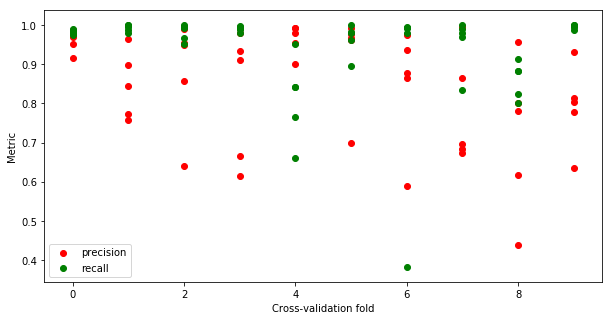

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

df = metrics_df[metrics_df.attempt != 'avg']

plt.figure(figsize=(10, 5))
# plt.scatter(x=df['split'], y=df['f1'], c='blue')
# plt.scatter(x=df['split'], y=df['accuracy'], c='green')
plt.scatter(x=df['split'], y=df['precision'], c='red')
plt.scatter(x=df['split'], y=df['recall'], c='green')
plt.xlabel('Cross-validation fold')
plt.ylabel('Metric')
plt.legend()

## Test Model on New Data

#### Train models

In [57]:
X.shape, y.shape

((23206, 56, 56, 1), (23206, 2))

In [59]:
model_list = []
for i in range(5):
    print('Attempt:', i)
    model = create_model(metrics=['accuracy'],
                         opt=SGD(lr=0.01, momentum=0.9, decay=0, nesterov=False))
    model.fit(X, y, batch_size=32, epochs=3, verbose=True)
    model_list.append(model)

Attempt: 0
Epoch 1/3
23206/23206 [==============================] - 18s - loss: 3.0373 - acc: 0.9757    
Epoch 2/3
23206/23206 [==============================] - 14s - loss: 0.1691 - acc: 0.9816    
Epoch 3/3
23206/23206 [==============================] - 14s - loss: 0.1711 - acc: 0.9825    
Attempt: 1
Epoch 1/3
23206/23206 [==============================] - 15s - loss: 3.0360 - acc: 0.9747    
Epoch 2/3
23206/23206 [==============================] - 14s - loss: 0.1793 - acc: 0.9804    
Epoch 3/3
23206/23206 [==============================] - 14s - loss: 0.1770 - acc: 0.9810    
Attempt: 2
Epoch 1/3
23206/23206 [==============================] - 15s - loss: 3.0336 - acc: 0.9741    
Epoch 2/3
23206/23206 [==============================] - 14s - loss: 0.1728 - acc: 0.9809    
Epoch 3/3
23206/23206 [==============================] - 14s - loss: 0.1662 - acc: 0.9805    
Attempt: 3
Epoch 1/3
23206/23206 [==============================] - 15s - loss: 3.0255 - acc: 0.9727    
Epoch 2/3
23206/

#### Fetch test data

In [71]:
gql_host = 'http://metaspace2020.eu/graphql'
iso_img_host = 'http://metaspace2020.eu'
jwt_token = '***'

In [70]:
all_annot_query = '''query($ds_id: String, $limit: Int) {
  allAnnotations(
    datasetFilter: {ids: $ds_id}
    filter: {
      database: "HMDB-v4"
      fdrLevel: 0.5
    }
    limit: $limit
    orderBy: ORDER_BY_MSM
    sortingOrder: DESCENDING
  ){
    sumFormula
    adduct
    fdrLevel
    msmScore
    isotopeImages {
      url
    }
  }
}'''

In [81]:
from requests import post, get
from io import BytesIO
from skimage.transform import resize
from PIL import Image

In [82]:
def fetch_ds_images(ds_id, limit=50):
    variables = {
        'ds_id': ds_id,
        'limit': limit
    }
    images = []
    resp = post(gql_host,
                json={'query': all_annot_query, 'variables': variables},
                headers={'Authorization': 'Bearer {}'.format(jwt_token)}).json()
    if 'errors' in resp:
        print(resp['errors'])
    else:
        ann_data = resp['data']['allAnnotations']
        for ann in ann_data:
            url = ann['isotopeImages'][0]['url']
            resp = get(iso_img_host + url)
            img = np.asarray(Image.open(BytesIO(resp.content)))
            img = img[:,:,0:1]
            img = img / 255
            images.append({'img': img,
                           'img_r': resize(img, (size, size), mode='reflect'),
                           'sf': ann['sumFormula'], 'add': ann['adduct'],
                           'fdr': ann['fdrLevel'], 'msm': ann['msmScore']})
    return images

In [122]:
# ds_id = '2018-01-24_19h05m40s'
# ds_id = '2018-06-23_22h43m54s'
ds_id = '2017-05-31_11h51m56s'
n = 20

In [123]:
ds_images = fetch_ds_images(ds_id=ds_id, limit=n)
ds_images_df = pd.DataFrame(ds_images).sort_values(by='msm', ascending=False)
ds_images_df.head()

,add,fdr,img,img_r,msm,sf
0,-H,0.05,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0.798153,C29H48O4
1,-H,0.05,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0.783151,C47H83O13P
2,-H,0.05,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0.753126,C43H78NO8P
3,-H,0.05,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0.710410,C30H48O3
4,-H,0.05,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0.690226,C18H34O4


In [124]:
img = ds_images[2]['img_r']

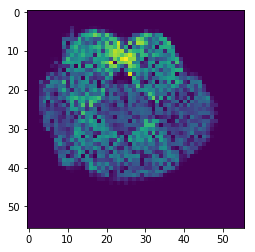

In [125]:
plt.imshow(img[:,:,0])

In [126]:
# plt.imshow(img[:,:,3])

#### Test data predictions

In [127]:
img_batch = np.stack(ds_images_df.img_r.values)
img_batch.shape

(20, 56, 56, 1)

In [128]:
img_score_list = []
for model in model_list:
    img_score = model.predict(img_batch)[:,1]
    img_score_list.append(img_score)

In [129]:
img_scores = np.stack(img_score_list).T
img_scores.shape

(20, 5)

[ 0.14228317  0.03843686  0.0503496   0.05771807  0.11825536] 0.0814086 ON SAMPLE


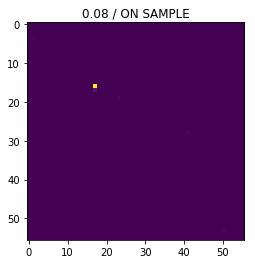

[  4.06995183e-03   1.40609845e-04   1.58704952e-05   2.37869052e-03
   1.24449925e-02] 0.00381002 ON SAMPLE


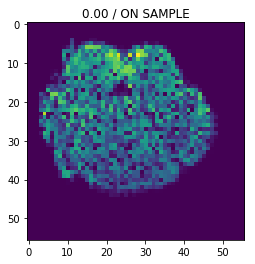

[  4.05033492e-03   3.19146988e-04   3.23706372e-05   4.00369754e-03
   1.46592185e-02] 0.00461295 ON SAMPLE


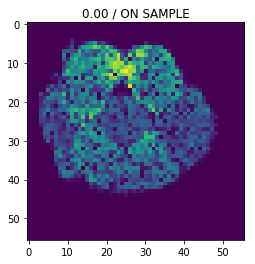

[ 0.14677522  0.03015147  0.04820774  0.05502435  0.10239697] 0.0765112 ON SAMPLE


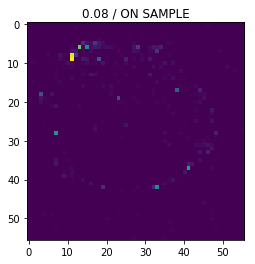

[  1.21647827e-02   7.53574364e-04   4.47510502e-05   7.25656794e-03
   1.00346794e-02] 0.00605087 ON SAMPLE


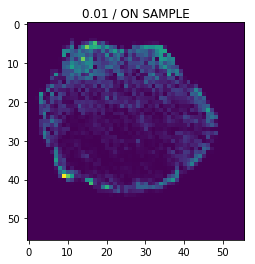

[  4.29195759e-04   4.86636927e-05   2.12753057e-05   1.97798782e-03
   1.27992341e-02] 0.00305527 ON SAMPLE


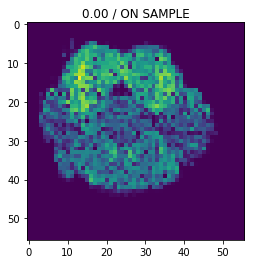

[  9.23075131e-04   7.93177824e-05   1.88519425e-05   2.35014735e-03
   1.33409929e-02] 0.00334248 ON SAMPLE


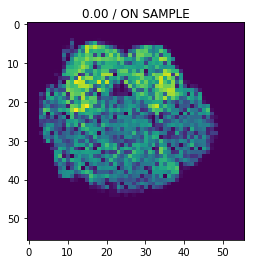

[  1.48524344e-03   1.65579491e-04   2.48253964e-05   2.95725558e-03
   1.26043102e-02] 0.00344744 ON SAMPLE


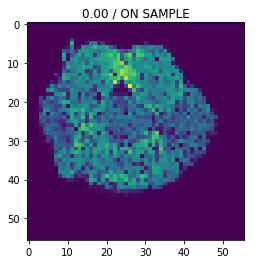

[  1.42973650e-03   5.06496908e-05   8.57417490e-06   1.95746659e-03
   9.81705543e-03] 0.0026527 ON SAMPLE


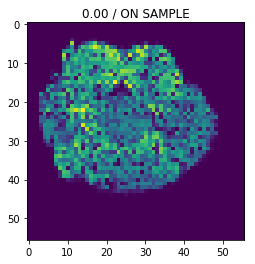

[ 0.02239717  0.00177662  0.00023227  0.00821081  0.02328813] 0.011181 ON SAMPLE


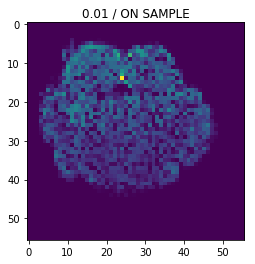

[  2.57030292e-03   1.71171021e-04   2.21658374e-05   2.86371144e-03
   1.39756575e-02] 0.0039206 ON SAMPLE


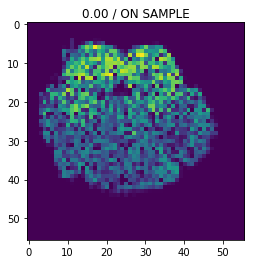

[  9.92099172e-04   1.05342537e-04   1.85995086e-05   2.13585421e-03
   1.32079478e-02] 0.00329197 ON SAMPLE


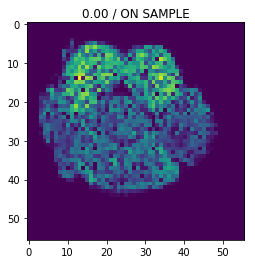

[  9.35557671e-03   5.45932679e-04   6.09292001e-05   5.36017586e-03
   1.91962719e-02] 0.00690378 ON SAMPLE


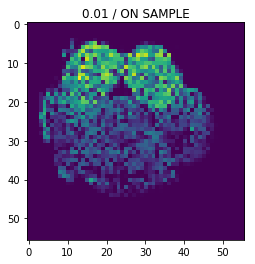

[ 0.00939971  0.00985888  0.00175034  0.02948961  0.03904228] 0.0179082 ON SAMPLE


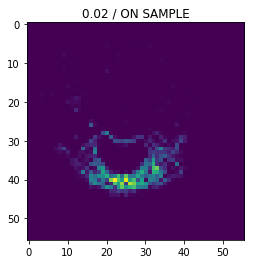

[  9.59235802e-03   2.92906101e-04   2.44462117e-05   3.99951078e-03
   1.37518374e-02] 0.00553221 ON SAMPLE


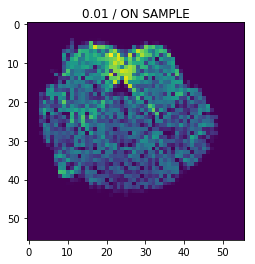

[ 0.01898968  0.01178986  0.00439257  0.03381367  0.08506764] 0.0308107 ON SAMPLE


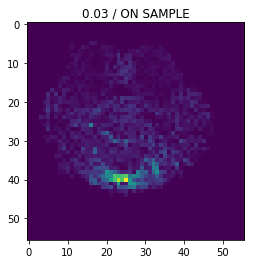

[  6.64268527e-03   2.59646244e-04   2.25158783e-05   3.91153013e-03
   1.20286848e-02] 0.00457301 ON SAMPLE


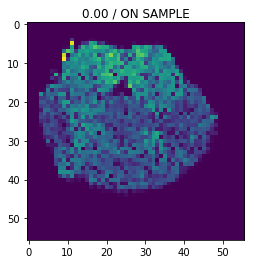

[ 0.15109365  0.04246306  0.0573952   0.05843361  0.12078827] 0.0860348 ON SAMPLE


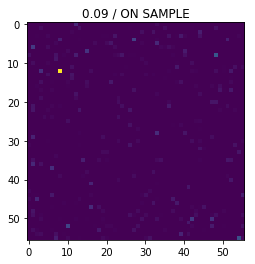

[ 0.02794888  0.01182274  0.0061906   0.03263274  0.08816965] 0.0333529 ON SAMPLE


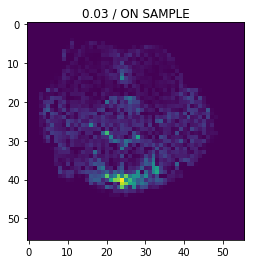

[  5.21485135e-03   9.76178926e-05   1.25376810e-05   2.03969353e-03
   1.18248714e-02] 0.00383791 ON SAMPLE


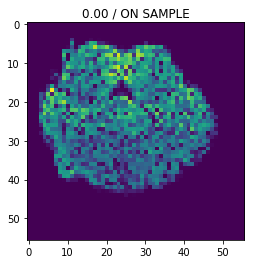

In [130]:
for img, scores in zip(img_batch, img_scores):
    label = 'OFF SAMPLE' if scores.mean() > 0.5 else 'ON SAMPLE'
    print(scores, scores.mean(), label)
    plt.imshow(img[:,:,0])
    plt.title('{:.2f} / {}'.format(scores.mean(), label))
    plt.show()